# How does the average over all scanned books look?

I'm not sure if this will be useful information but it's easy to compute and at worst it will be a nice visualization.

In [1]:
import cv2 as cv
from glob import glob
import pandas as pd
import numpy as np
import itertools
from helpers.features import log_progress, show_image

## First, read in metadata

In [2]:
info = pd.read_csv("bukan-overview.csv")

In [3]:
useful_info = (info[info["K?"] == "x"]
    .drop(["書名（統一書名）", "Comment", "(単位)", "冊数等", "刊・写", "オープンデータ分類", "公開時期", "K?"], 1)
    .astype({"Pages per Scan": int, "国文研書誌ID": int})
    .set_index("国文研書誌ID"))

In [4]:
useful_info

,原本請求記号,刊年・書写年,（西暦）,Pages per Scan,Aspect
国文研書誌ID,,,,,
200018462,ＭＹ－１４９０－４,文政２,1819,2,Portrait
200018466,ＭＹ－１４９０－７,天保１５,1844,2,Portrait
200018476,ＭＹ－１４９０－８,弘化３,1846,2,Portrait
200018713,ＭＹ－１２０１－５３,［貞享３］,[1686],2,Landscape
200018714,ＭＹ－１２０１－５４,貞享３,1686,2,Landscape
...,...,...,...,...,...
200019654,ＭＹ－１２０１－３１８,慶応４,1868,2,Landscape
200019661,ＭＹ－１２０１－３２４,嘉永６,1853,2,Landscape
200019662,ＭＹ－１２０１－３２５,安政３,1856,2,Landscape


## Which layouts do we have?

Altough the scans are mostly very uniform, there are some differences in the book layouts. After evaluation, it seems like there are two main layouts:

* One wide (landscape aspect) page per scanned picture
* Two tall (portrait aspect) pages per scanned picture

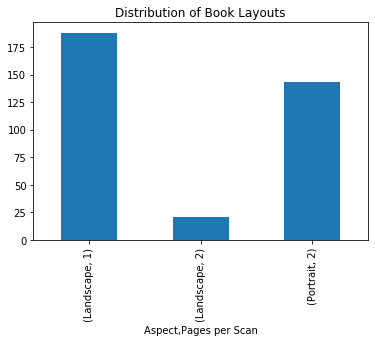

In [5]:
useful_info.groupby(["Aspect", "Pages per Scan"]).count()["原本請求記号"].plot.bar(
    title="Distribution of Book Layouts")

## Computing the average

### Landscape, 1-page

In [6]:
landscape = useful_info[useful_info["Aspect"] == "Landscape"]
landscape = landscape[landscape["Pages per Scan"] == 1]

In [7]:
landscape_paths = list(itertools.chain.from_iterable(glob(f"data/{idx}/image/*.jpg") for idx in landscape.index))

In [8]:
def read_and_convert(img_path):
    img = cv.imread(img_path, flags=cv.IMREAD_REDUCED_GRAYSCALE_4)
    img = img.astype(np.float64) / 255
    return img

In [9]:
def average_images(paths):
    init_image = np.zeros_like(read_and_convert(paths[0]), dtype=np.float64)
    image_shape = init_image.shape
    for image in log_progress((read_and_convert(path) for path in paths), every=10, name="Image", size=len(paths)):
        if image.shape != image_shape:
            height, width = image_shape
            image = cv.resize(image, (width, height))
        init_image += image
    return init_image / len(paths)

In [10]:
landscape_average = average_images(landscape_paths)

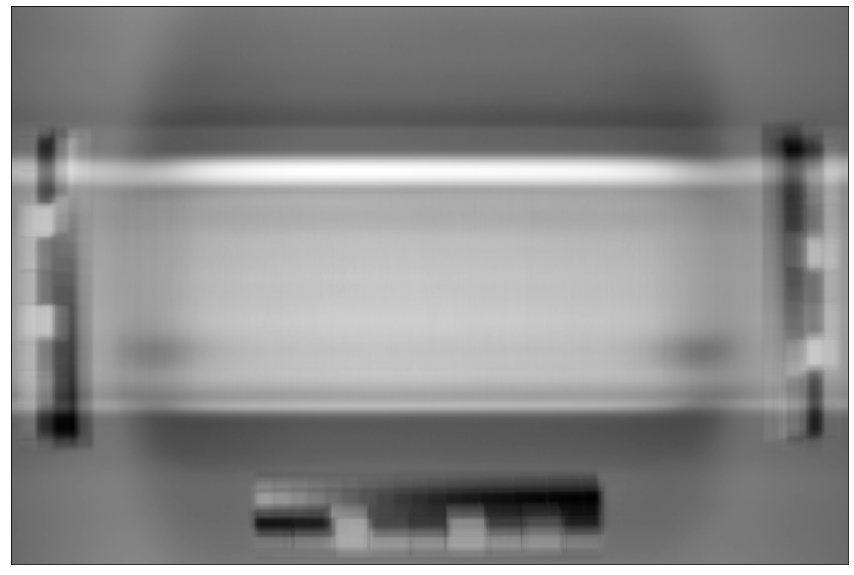

In [11]:
show_image(landscape_average, (15, 15))

In [12]:
landscape_average_uint8 = (landscape_average * 255).astype(np.uint8)
cv.imwrite("landscape_average.png", landscape_average_uint8)

True

### Portrait, 2-pages

In [13]:
portrait = useful_info[useful_info["Aspect"] == "Portrait"]
portrait = portrait[portrait["Pages per Scan"] == 2]

In [14]:
portrait_paths = list(itertools.chain.from_iterable(glob(f"data/{idx}/image/*.jpg") for idx in portrait.index))

In [15]:
portrait_average = average_images(portrait_paths)

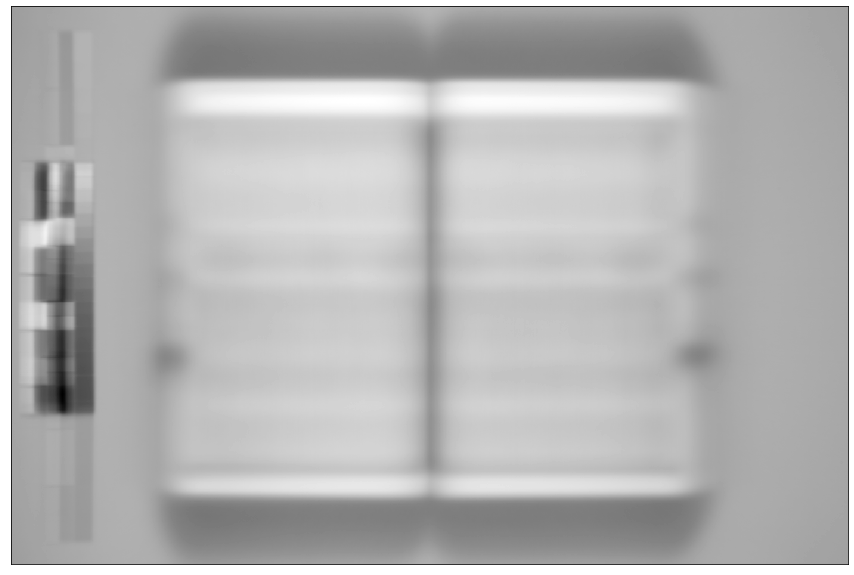

In [16]:
show_image(portrait_average, (15, 15))

In [17]:
portrait_average_uint8 = (portrait_average * 255).astype(np.uint8)
cv.imwrite("portrait_average.png", portrait_average_uint8)

True